In [14]:
import pandas as pd
import os
import numpy as np
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from multiprocessing import Pool
import warnings
import h5py
warnings.filterwarnings('ignore')

In [14]:
#Для H3K27ac были взяты broad пики!
targets = [("H3K4me1", "_narrow"), ("H3K4me2", "_narrow"), ("H3K4me3", "_narrow"), ("H3K79me2", ""), 
           ("H3K9ac", "_narrow"), ("H3K9me3", ""), ("H4K20me1", "")]

In [15]:
def getFiles(target, file_end_filter):
    files = []
    for dirpath, dirnames, filenames in os.walk("/data/mazurovev/" + target[0] + "/"):
        for filename in sorted([f for f in filenames if not f.endswith(file_end_filter)])[:1]:
            files.append(dirpath + "/" + filename.split('.')[0] + target[1] + "_" + file_end_filter)
    
    return files

In [16]:
def mergePeaks(files, target, output_name):
    x = BedTool(files[0])
    x.cat(*files[1:], force_truncate=True, output="../all_marks/" + target + "/" + output_name + ".bed")
    
    mp = pd.read_csv("../all_marks/" + target + "/" + output_name + ".bed", sep="\t", header=None)
    peak_names = []
    for i in range(0, mp.shape[0]):
        peak_names.append("peak_" + str(i))
        
    mp[3] = peak_names
    
    mp.to_csv("../all_marks/" + target + "/" + output_name + ".bed", sep="\t", header=None, index=None)

In [17]:
mergePeaks(getFiles(("H3K27me3", ""), "peaks.narrowPeak"), "H3K27me3", "merged_narrow_peaks_first_in_biosample")

In [13]:
mergePeaks(getFiles(("H3K27me3", ""), "narrow_peaks.bed"), "H3K27me3", "merged_narrow_2_peaks_first_in_biosample")

In [17]:
mergePeaks(getFiles(("H3K27me3", ""), "peaks.broadPeak"), "H3K27me3", "merged_broad_2_peaks_first_in_biosample")

In [16]:
for target in targets:
    print("merge " + target[0] + " peaks...")
    
    if not os.path.exists("../all_marks/" + target[0] + "/"):
        os.makedirs("../all_marks/" + target[0] + "/")
    
    mergePeaks(getFiles(target, "peaks.bed"), target, "merged_peaks_first_in_biosample")

merge H3K4me1 peaks...
merge H3K4me2 peaks...
merge H3K4me3 peaks...
merge H3K79me2 peaks...
merge H3K9ac peaks...
merge H3K9me3 peaks...
merge H4K20me1 peaks...


In [20]:
pd.read_csv("../all_marks/H3K27me3/merged_narrow_peaks_first_in_biosample.bed", sep="\t", header=None).shape

(981241, 4)

In [21]:
pd.read_csv("../all_marks/H3K27me3/merged_peaks_first_in_biosample.bed", sep="\t", header=None).shape

(267955, 4)

In [ ]:
#========================================== графики ====================================================================

In [19]:
sns.set(color_codes=True)
rcParams['figure.figsize'] = 11.7,8.27
rcParams["patch.force_edgecolor"] = True

In [346]:
files = ["../H3K27me3/peaks/" + f for f in os.listdir("../H3K27me3/peaks") if f.startswith("ENC")]

In [5]:
len(files)

77

In [325]:
d = pd.read_csv("../H3K27me3/H3K27me3_filtered_by_biosample.csv", sep=';', index_col=False)

In [347]:
peaks = []
for index, row in d.iterrows():
    peaks.append((row['File accession'], row['norm_factor'], pd.read_csv("../H3K27me3/peaks/" + row['File accession'] + "_peaks.bed", sep="\t", header=None).shape[0]))

In [330]:
#!!6 - нет пиков, у 9 меньше 1000 пиков - возможно влияет на корреляцию
pd.read_csv("../H3K27me3/peaks/ENCFF488SNL_peaks.bed", sep="\t", header=None)

,0
0,"track name=""peak"" description=""peak"" type=gapp..."


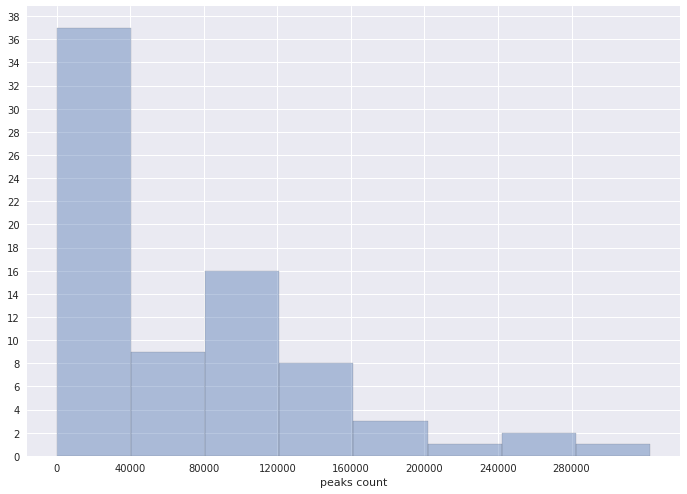

In [348]:
ax = sns.distplot([p[2] for p in peaks], bins=8, kde=False)
ax.set_xticks(range(0, 320000, 40000))
ax.set_yticks(range(0, 40, 2))
#ax.set_xticklabels(["{:.1e}".format(x) for x in ax.get_xticks()])
ax.set(xlabel='peaks count')
plt.show()

In [349]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_peaks_count_in_experiments_hist.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#Гистограмма длин пиков +
#Гены с пиками/без пиков - barplot, так же пики в генах/пики не в генах +
#Кол-во генов на пик, количество пиков на ген - barplot +
#Где находятся пики относительно генов(перед, внутри, после) - barplot +
#сколько генов с пиками с одинаковым знаком корреляции/с разными знаками - barplot

In [350]:
peaks = pd.read_csv("../H3K27me3/peaks/merged_peaks.bed", sep='\t', header=None)

In [285]:
peaks.shape

(277972, 4)

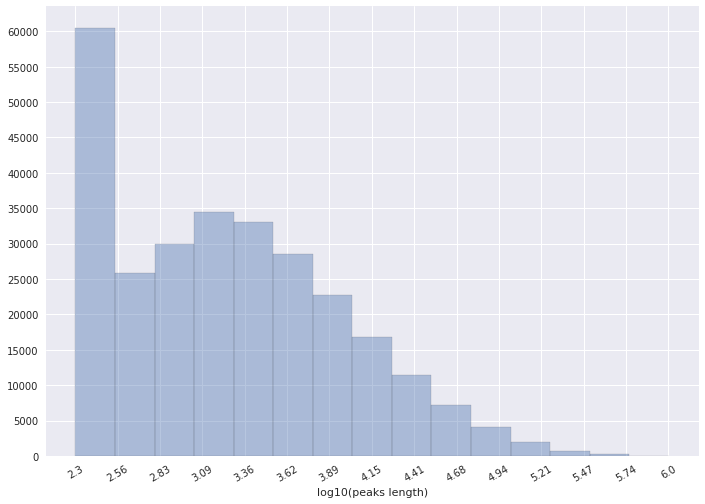

In [351]:
ax = sns.distplot([np.log10(l) for l in peaks[2] - peaks[1]], bins=15, kde=False)
ax.set_xticks(np.linspace(2.3, 6, 15))
ax.set_yticks(range(0, 62500, 5000))
ax.set_xticklabels(np.around(ax.get_xticks(), decimals=2), rotation=30)
ax.set(xlabel='log10(peaks length)')
plt.show()

In [352]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_peaks_length_hist.png", bbox_inches='tight', pad_inches = 0)

In [353]:
#Всего 57736 генов
anno = pd.read_csv("../H3K27me3/peaks/anno_merged_peaks.csv", sep="\t", header=None)

In [113]:
len(anno[6].unique())

53397

In [117]:
len(anno[5].unique())

176917

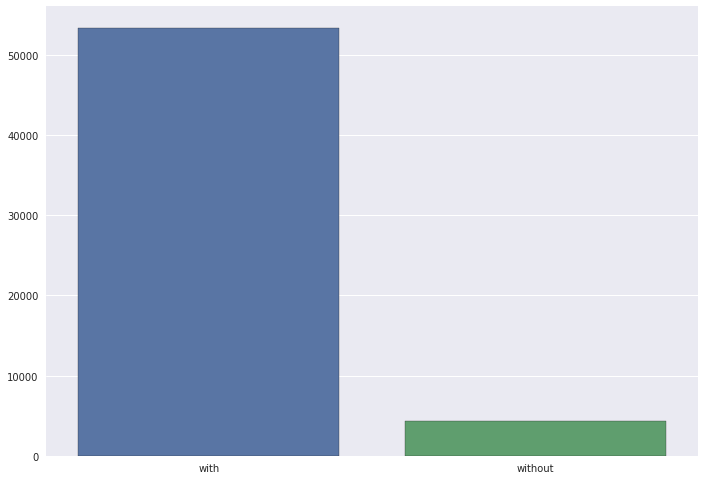

In [373]:
ax = sns.barplot(x=['with', 'without'], y=[53397, 57736 - 53397])

In [374]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_genes_with_peaks_barplot.png", bbox_inches='tight', pad_inches = 0)

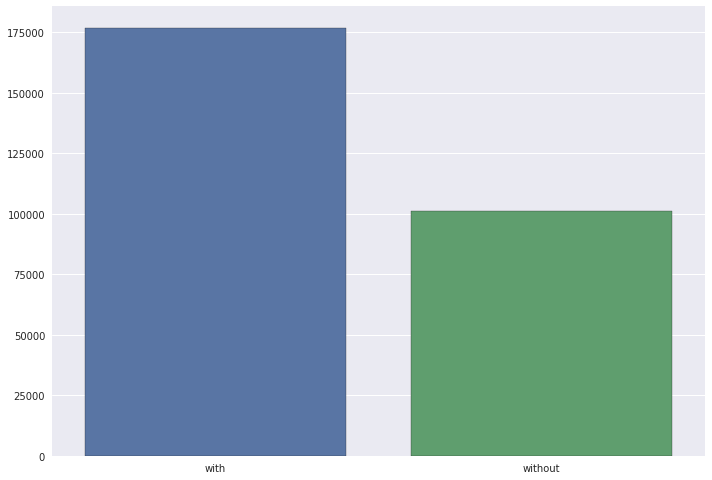

In [375]:
ax = sns.barplot(x=['with', 'without'], y=[176917, 277972 - 176917])

In [376]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_peaks_with_genes_barplot.png", bbox_inches='tight', pad_inches = 0)

In [336]:
#кол-во пиков на ген
15415+4256+540

20211

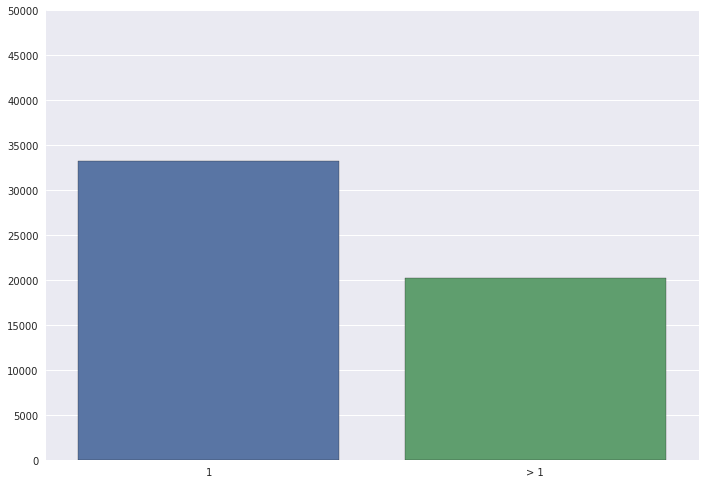

In [381]:
ax = sns.barplot(x=['1', '> 1'], y=[33186, 20211])
ax.set_yticks(range(0, 50001, 5000))
plt.show()

In [382]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_peaks_in_gene_count_barplot.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#кол-во генов на пик

In [320]:
34578+ 275+ 33

34886

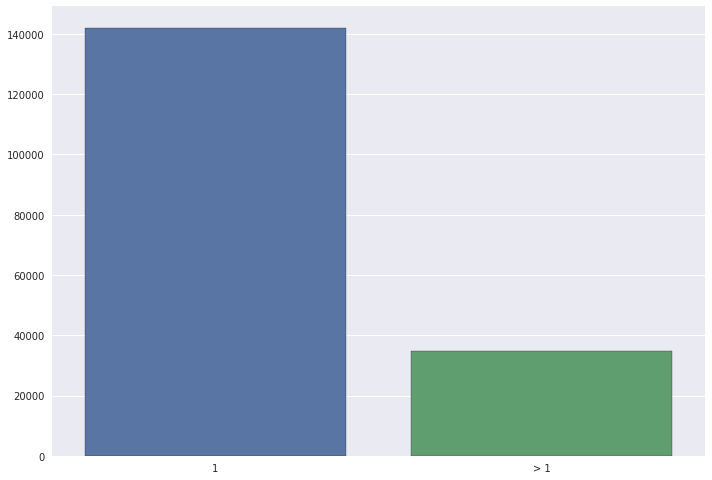

In [383]:
ax = sns.barplot(x=['1', '> 1'], y=[142031, 34886])
#ax.set_title('gene in peaks count')
#ax.set_yticks(range(0, 50001, 5000))
plt.show()

In [384]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_genes_in_peak_count_barplot.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#где находится пик относительно тела гена(начало, середина, конец)

In [362]:
pos = anno[10].value_counts()

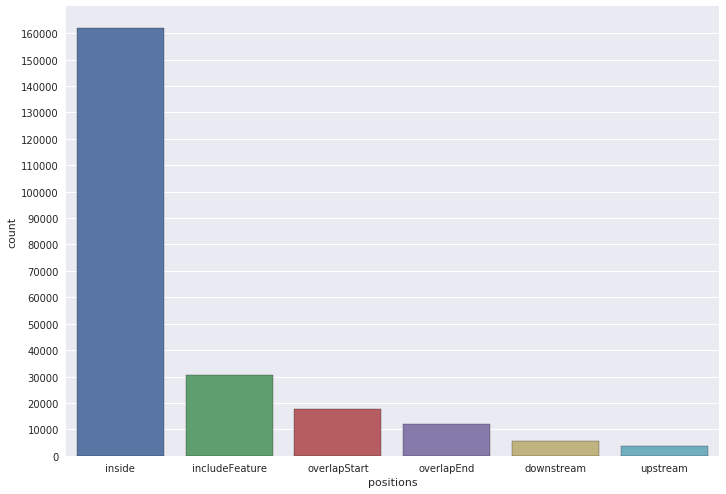

In [363]:
#inside: - пик внури гена
#includeFeature - ген внутри пика
ax = sns.barplot(pos.index, pos.values)
ax.set(xlabel='positions', ylabel='count')
ax.set_yticks(range(0, 160001, 10000))
plt.show()

In [364]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_peaks_positions_barplot.png", bbox_inches='tight', pad_inches = 0)

In [213]:
#сколько генов с пиками с одинаковым знаком корреляции/с разными знаками + распределение знаков - barplot
df = pd.read_csv("../H3K27me3/peaks/lncRNA_peaks_gene_association.tsv", sep="\t")

In [262]:
gb = df.groupby(['lncRNA', 'gene']).corr.agg({"sign": checkSigns, "count": 'count'})

In [264]:
#Сколько есть пар РНК-Ген, связанных через больше одного пика и одинаковый знак?
#Одинаковое распределения кол-ва пиков в генах в обоих случаях
#TODO: Отличаются ли как нибудь пары РНК-ген с разными знаками от тех, у которых одинаковые знаки??
gb = gb[gb['count'] != 1]

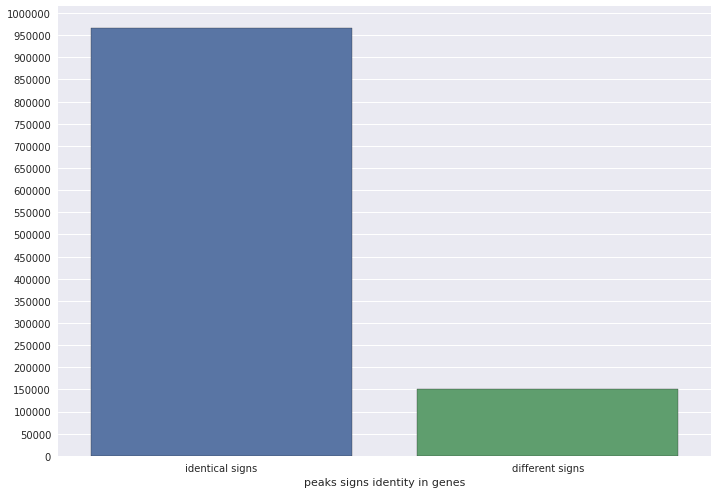

In [369]:
ax = sns.barplot(x=['identical signs', 'different signs'], y=[966987, 150462])
ax.set_yticks(range(0, 1000001, 50000))
ax.set(xlabel='peaks signs identity in genes')
plt.show()

In [370]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../H3K27me3/plots/MergePeaks_peaks_in_genes_sign_identity_barplot.png", bbox_inches='tight', pad_inches = 0)

In [242]:
def checkSigns(x):
    if len(x) > 1:
        if((all(item >= 0 for item in x) or all(item < 0 for item in x))):
            return 1
        else:
            return -1
    else:
        return 0

In [ ]:
#===========================================methylation

In [15]:
files = []
for dirpath, dirnames, filenames in os.walk("/data/mazurovev/methylation/"):
    for filename in sorted(filenames)[:1]:
        #Делаем путем к файлу с пиками
        files.append(dirpath + "/" + filename)

In [16]:
from subprocess import Popen, PIPE
import sys
def callWithNiceOutput(cmd):
    proc = Popen(cmd, stdout=PIPE, stderr=PIPE, shell=True, bufsize=-1)
    
    for line in proc.stdout:
        print("output: ")
        print(line)
        sys.stdout.flush()
    
    for line in proc.stderr:
        print("error: ")
        print(line)
        sys.stdout.flush()

In [17]:
def smallBed(f):
    callWithNiceOutput("cut -f 1,2,3,10,11 " + f + " > " + f + "small")

In [18]:
pool = Pool(processes=27)
data = pool.map(smallBed, files)

pool.close()
pool.join()

In [ ]:
#Смерджим - получим позиции в которых хотя бы в одном эксперименте есть занчение [0, 1]
#Потом делаем матрицу где строки - эксперименты, а стоблцы  - найденные выше пики, ставим NA не 0, если нет
#значения
#Удаляем столбцы где больше 8 NA (т.к. 27 экспериментов)

In [2]:
files = []
for dirpath, dirnames, filenames in os.walk("/data/mazurovev/methylation/"):
    for filename in sorted([f for f in filenames if f.endswith(".bedsmall")])[:1]:
        #Делаем путем к файлу с пиками
        files.append(dirpath + "/" + filename)

In [3]:
beds = []
for i, f in enumerate(files):
    tmp = pd.read_csv(f, sep="\t", header=None)
    tmp = tmp[tmp[3] != 0][[0,1,2,4]]
    beds.append(tmp.sort_values(by=[0, 1]))
    print(f + " number " + str(i) + " done!")

/data/mazurovev/methylation/UBERON:0000945/ENCFF435SPL.bedsmall number 0 done!
/data/mazurovev/methylation/UBERON:0002084/ENCFF536RSX.bedsmall number 1 done!
/data/mazurovev/methylation/UBERON:0002106/ENCFF200MJQ.bedsmall number 2 done!
/data/mazurovev/methylation/UBERON:0001159/ENCFF157POM.bedsmall number 3 done!
/data/mazurovev/methylation/EFO:0001196/ENCFF254DBF.bedsmall number 4 done!
/data/mazurovev/methylation/UBERON:0000992/ENCFF189WPY.bedsmall number 5 done!
/data/mazurovev/methylation/UBERON:0002369/ENCFF210XTE.bedsmall number 6 done!
/data/mazurovev/methylation/EFO:0003042/ENCFF092FNE.bedsmall number 7 done!
/data/mazurovev/methylation/UBERON:0002048/ENCFF039JFT.bedsmall number 8 done!
/data/mazurovev/methylation/UBERON:0008952/ENCFF733EFJ.bedsmall number 9 done!
/data/mazurovev/methylation/UBERON:0000948/ENCFF560SMW.bedsmall number 10 done!
/data/mazurovev/methylation/EFO:0001187/ENCFF064GJQ.bedsmall number 11 done!
/data/mazurovev/methylation/CL:0000192/ENCFF297CJG.bedsmall

In [12]:
first = beds[0]
for i, n in enumerate(beds):
    if i == 0:
        continue
    first = first.merge(beds[i], on=[0,1,2], how='outer')   
    print(str(i) + " done!")

1 done!
2 done!
3 done!
4 done!
5 done!
6 done!
8 done!
9 done!
10 done!
11 done!
12 done!
13 done!
14 done!
15 done!
16 done!
17 done!
18 done!
19 done!
20 done!
21 done!
22 done!
23 done!
24 done!
25 done!
26 done!


In [13]:
first = first.set_index([0,1,2])

In [14]:
t = first.index

In [15]:
with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_outer.hdf5", 'w') as f:
        f.create_dataset("signal_matrix", data=first.values)
        string_dt = h5py.special_dtype(vlen=str)
        f.create_dataset("files_names", data=np.array(files, dtype='object'), dtype=string_dt)
        f.create_dataset("coords", data=np.array(t, dtype='object'), dtype=string_dt)

In [2]:
with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_outer.hdf5", 'r') as f:
    data = f['signal_matrix'][:]
    coords = f['coords'][:]
    files = f['files_names'][:]

In [3]:
data.shape

(57799927, 27)

In [4]:
#Для каждого места с метилированием может быть свой набор экспериментов, это норма? - да
filtered = data[[True if i < 8 else False for i in np.isnan(data).sum(axis=1).tolist()]]

In [5]:
filtered.shape

(53699858, 27)

In [20]:
c = coords[[True if i < 8 else False for i in np.isnan(data).sum(axis=1).tolist()]]

In [26]:
with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_outer_filtered.hdf5", 'w') as f:
        f.create_dataset("signal_matrix", data=filtered)
        string_dt = h5py.special_dtype(vlen=str)
        f.create_dataset("files_names", data=np.array(files, dtype='object'), dtype=string_dt)
        f.create_dataset("coords", data=np.array(c, dtype='object'), dtype=string_dt)